In [454]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.preprocessing as skl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten
from tensorflow.keras.optimizers import RMSprop
#from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras import metrics
# import data file here

In [479]:
df = pd.read_excel('data/z_Masterfile.xlsx').fillna(0)
df[['WTI_Change_PCT', 'WTI_HL_PCT', 'Brent_change_PCT', 'Brent_HL_PCT']] = df[['WTI_Change_PCT', 'WTI_HL_PCT', 'Brent_change_PCT', 'Brent_HL_PCT']]*100
df.head()

,Date,WTI_price,WTI_open,WTI_Change_PCT,WTI_HL_PCT,Brent_Price,Brent_Open,Brent_change_PCT,Brent_HL_PCT
0,1983-04-01,30.63,29.30,4.65,5.582762,0.0,0.0,0.0,0.0
1,1983-05-01,30.25,30.66,-1.24,4.859504,0.0,0.0,0.0,0.0
2,1983-06-01,31.38,30.35,3.74,4.939452,0.0,0.0,0.0,0.0
3,1983-07-01,32.00,31.42,1.98,3.187500,0.0,0.0,0.0,0.0
4,1983-08-01,31.59,32.05,-1.28,2.690725,0.0,0.0,0.0,0.0


In [478]:
features_considered = ["WTI_price", "WTI_open", "WTI_Change_PCT", "WTI_HL_PCT",
                       "Brent_Price", "Brent_Open", "Brent_change_PCT", "Brent_HL_PCT"]
features = df[features_considered]
features.index = df["Date"]
features.tail()


,WTI_price,WTI_open,WTI_Change_PCT,WTI_HL_PCT,Brent_Price,Brent_Open,Brent_change_PCT,Brent_HL_PCT
Date,,,,,,,,
2019-06-01,58.47,53.42,9.29,15.956901,66.55,61.64,3.19,11.119459
2019-07-01,58.58,59.27,0.19,10.617958,65.17,65.05,-2.07,9.759092
2019-08-01,55.10,57.85,-5.94,13.557169,60.43,64.09,-7.27,14.330630
2019-09-01,54.07,55.00,-1.87,19.493249,60.78,58.80,0.58,24.218493
2019-10-01,53.22,54.23,-1.57,7.196543,58.66,59.41,-3.49,6.699625


(439, 8)
Trained Data Points: 351
Test Data Points:  88


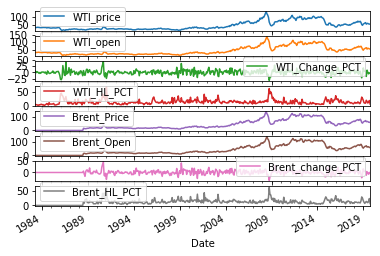

In [480]:
features.plot(subplots=True)
time_steps = df.index.size
TRAIN_SPLIT = int(np.rint(time_steps * 0.8))
dataset = features.values
### LOSS CANT BE CALCULATED
print(dataset.shape)
print("Trained Data Points:", TRAIN_SPLIT)
print("Test Data Points: ", time_steps-TRAIN_SPLIT)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A88084F320>,
      dtype=object)

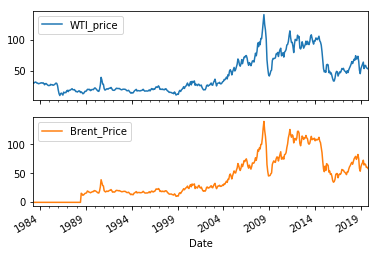

In [493]:
features[["WTI_price", "Brent_Price"]].plot(subplots=True)

In [490]:
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
#Change % mean and std
print(data_mean, data_std)


[37.18173789 37.00672365  0.76524217 14.75089881 32.89193732 32.67042735
  0.90017094 11.61317573] [26.92259397 26.83107766  9.66156405  8.91209192 32.13546266 31.98591155
  8.58299372  9.04868392]


In [483]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

def multi_step_plot(history, true_future, prediction, target, path=None, name=None):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, target]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  if path is  not None:
    plt.savefig(path + name)
  plt.show()

def create_time_steps(length):
  return list(range(-length, 0))

def plot_train_history(history, title, path=None, name=None):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  if path is  not None:
    plt.savefig(path + name)

  plt.show()




In [484]:
past_history = 24
future_target = 12
STEP = 1
BUFFER = 25
BATCH_SIZE = 40


x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 2], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 2],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP)

# Looking Righteous
#print("y_train: ", y_train_single.shape, "\ny_val: ", y_val_single.shape)
#print("y_train: ", y_train_single, "\ny_val: ", y_val_single)
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()






Single window of past history : (24, 8)

 Target temperature to predict : (12,)


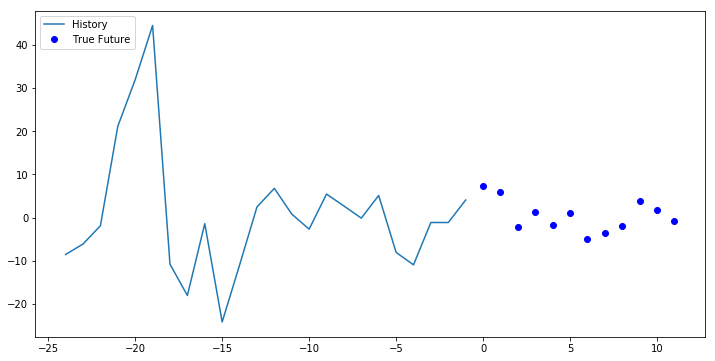

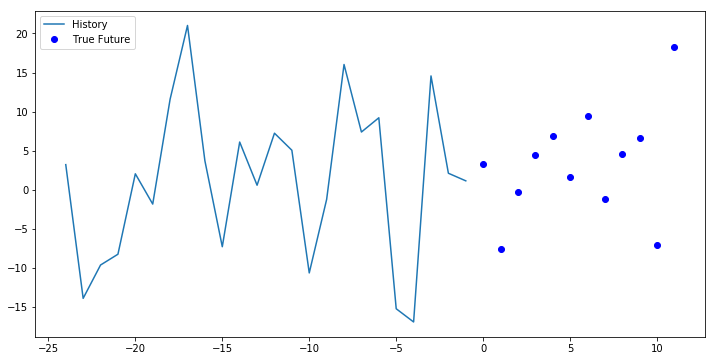

In [485]:

## SOMETHIG WONG

for x, y in train_data_multi.take(2):
  multi_step_plot(x[0], y[0], np.array([0]), 2)

In [486]:
print(x_train_multi.shape[-2:])

(24, 8)


In [488]:
EPOCHS = 15
EVALUATION_INTERVAL = 35


Train for 35 steps, validate for 50 steps
Epoch 1/15
35/35 [==============================] - 10s 294ms/step - loss: 97.7207 - accuracy: 0.0000e+00 - val_loss: 97.7950 - val_accuracy: 0.0000e+00
Epoch 2/15
35/35 [==============================] - 2s 64ms/step - loss: 96.8220 - accuracy: 0.0000e+00 - val_loss: 97.6245 - val_accuracy: 0.0000e+00
Epoch 3/15
35/35 [==============================] - 2s 65ms/step - loss: 98.6405 - accuracy: 0.0000e+00 - val_loss: 97.3816 - val_accuracy: 0.0000e+00
Epoch 4/15
35/35 [==============================] - 2s 67ms/step - loss: 96.7331 - accuracy: 0.0000e+00 - val_loss: 97.1024 - val_accuracy: 0.0000e+00
Epoch 5/15
35/35 [==============================] - 2s 67ms/step - loss: 95.4864 - accuracy: 0.0000e+00 - val_loss: 97.1555 - val_accuracy: 0.0000e+00
Epoch 6/15
35/35 [==============================] - 2s 66ms/step - loss: 89.2961 - accuracy: 0.0000e+00 - val_loss: 96.8564 - val_accuracy: 0.0000e+00
Epoch 7/15
35/35 [==============================] 

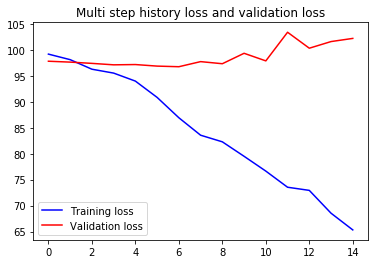

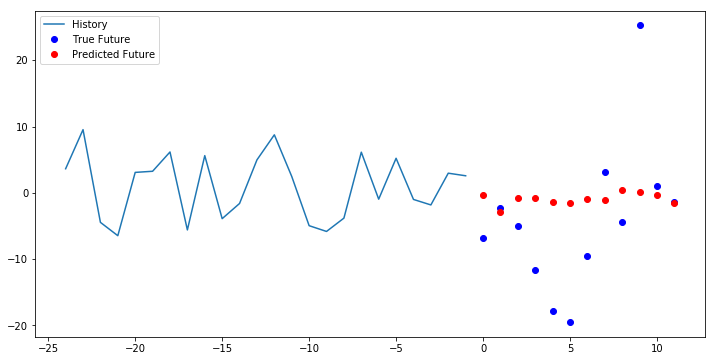

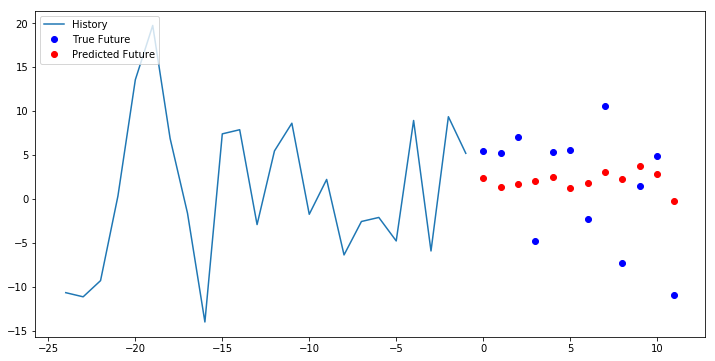

In [489]:
#RMSprop(learning_rate=0.0001, rho=0.9)

kickass_lstm_model = Sequential()
kickass_lstm_model.add(LSTM(64,
                            return_sequences=True,
                            input_shape=x_train_multi.shape[-2:]))
kickass_lstm_model.add(LSTM(64, activation='relu'))
kickass_lstm_model.add(Dense(12))
kickass_lstm_model.compile(optimizer=RMSprop(learning_rate=0.001, rho=0.9), loss='mean_squared_error', metrics=[metrics.accuracy])

'''for x, y in val_data_multi.take(1):
  print (kickass_lstm_model.predict(x, steps=1).shape)'''

multi_step_history = kickass_lstm_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)


name = '64lstm-64lstm-12dnse-0001LR-9rho-2'
tname = '64-64-12-0001-9_train'
path = 'graphs/RMS/'

plot_train_history(multi_step_history, "Multi step history loss and validation loss", path, tname)
for x, y in val_data_multi.take(2):
  multi_step_plot(x[0], y[0], kickass_lstm_model.predict(x)[0], 2, path, name)





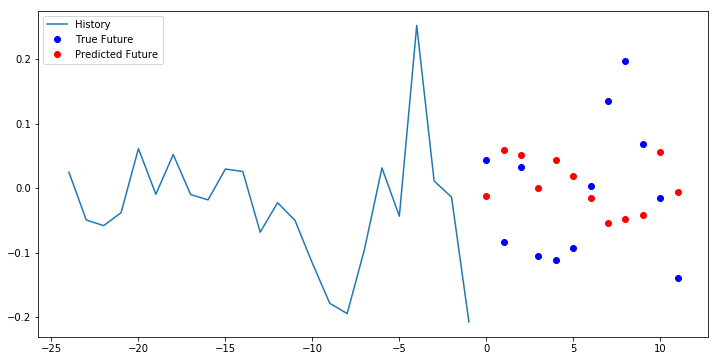

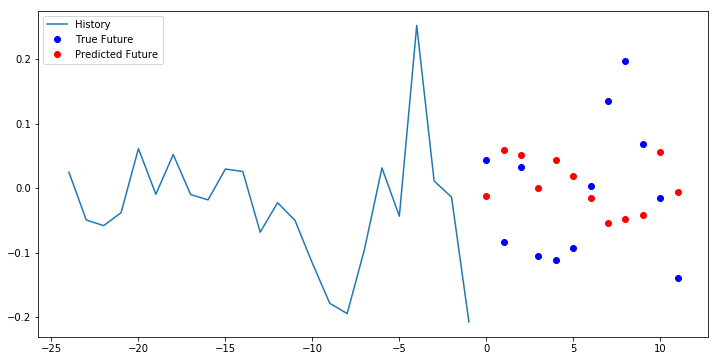

In [445]:
for x, y in val_data_multi.take(2):
  multi_step_plot(x[0], y[0], kickass_lstm_model.predict(x)[0], 2, path, name)

loss: 0.007662, acc: 
